In [132]:
import time
import pandas as pd
import base64
import random
import requests
import json
from urllib.parse import urlencode
from IPython.core.display import HTML 
from xml.sax import saxutils
from functools import lru_cache
from svgpathtools import svg2paths

In [162]:
FILENAME = "qvina02_all"

In [163]:
with open(f"../data/{FILENAME}.txt", "r") as f:
    ligand_list = f.read().split("\n")
    columns = ["Collection", "Ligand", "Highest-Score", "NA"]
    ligand_list = [ligand.strip().split() for ligand in ligand_list]
    ligand_df = pd.DataFrame(ligand_list, columns=columns)
#     ligand_df = ligand_df.rename(columns=ligand_df.iloc[0]).drop(ligand_df.index[0])

In [164]:
with open("../data/ligands.txt", "r") as f:
    ligands_smiles = f.read().split("\n")
    columns = ["Ligand", "Smiles"]
    ligands_smiles = [l for l in ligands_smiles if l]
    ligands_smiles = list(zip(ligands_smiles[::2], ligands_smiles[1::2]))
    ligands_smiles_df = pd.DataFrame(ligands_smiles, columns=columns)
    ligands_smiles_df = ligands_smiles_df.drop_duplicates()

In [165]:
ligand_df = ligand_df.merge(ligands_smiles_df, how="left", on="Ligand")

In [166]:
ligand_df

,Collection,Ligand,Highest-Score,NA,Smiles
0,JBDDDG_00000,PV-001829600218_1_T1,-7.7,1,C[C@@]1(N=C(O)NC1=O)C1=CC=CC(=C1)C(=O)NCCC(=O)...
1,JBDDCG_00000,PV-001836769525_1_T1,-7.5,1,OC1=NC2(CCCC2)C(=O)N1CC(=O)NNC(=O)CN1CCN(CC1)C...
2,JBDDCG_00000,PV-001872914269_1_T1,-7.4,1,OC1(CNC(=O)c2cccc(c2)S(=O)(=O)N2CCNC(=O)C2)CCC...
3,JBDDDG_00000,PV-001829600017_2_T3,-7.4,1,C[C@]1(NC(=O)N=C1O)C1=CC=C(C=C1)C(=O)NCCC(=O)N...
4,JBDDCG_00000,PV-001850780878_2_T1,-7.3,1,OC1=C(C(=O)NNC(=O)CCN2CCN(CC2)C(=O)[C@H]2CCCO2...
...,...,...,...,...,...
37597,JBFCFG_00000,PV-002008653608_2_T1,-3.5,1,C[C@@H](NS(C)(=O)=O)c1nnc(N2CCC(CC2)S(C)(=O)=O...
37598,JBFCFG_00001,PV-002041695183_4_T1,-3.5,1,COCC[C@@](C)(O)Cn1c(nnc1N1CCN(CC1)C(=O)[C@@H]1...
37599,JBEAEG_00000,PV-001939926551_1_T1,-3.4,1,COCCN(CCOC)S(=O)(=O)N1CCN([C@H]2CS(=O)(=O)C[C@...
37600,JBFCEG_00003,PV-002035337131_7_T1,-3.3,1,CNC(=O)[C@]1(C)CCN(C1)c1nnc([C@@H](C)OCCOC)n1C...


In [5]:
@lru_cache(maxsize=None)
def search_real_by_id(real_id):
    """Returns ligand object if found an an object containing the exception if failed. """
    query = {
        "controlPath": "ids",
        "PageSize": "",
        "PageNumber": "",
        "reqMethod": "POST",
        "reqtime": 1618565991600,
        "jsonData": {}
    }
    query["jsonData"] = json.dumps({"search": real_id})

    payload = urlencode(query)
    headers = {
        "x-requested-with": "XMLHttpRequest",
        "content-type": "application/x-www-form-urlencoded; charset=UTF-8",
    }
    url = "https://www.enaminestore.com/search.realsearch:searchrealidsrequest"
    
    response = requests.request("POST", url, headers=headers, data=payload)      
    
    if "exception" in response:
        raise Exception(response["exception"])
    
    return response.json()

In [6]:
@lru_cache(maxsize=None)
def smiles_to_image(smiles_str, width=400, height=300):
    query = {
        "reqtime": 1618565992221,
        "jsonData": {}
    }
    query["jsonData"] = json.dumps({"structure": smiles_str, "parameters": f"png:w{width},h{height}"})

    payload = urlencode(query)
    headers = {
        "x-requested-with": "XMLHttpRequest",
        "content-type": "application/x-www-form-urlencoded; charset=UTF-8",
    }
    url = "https://www.enaminestore.com/search.realsearch:smilestoimagerequest"
    response = requests.request("POST", url, headers=headers, data=payload)
    
    if "exception" in response:
        raise Exception(response["exception"])
    
    return response.json()

In [7]:
def get_ligand_by_id(real_id):
    try:
        response = search_real_by_id(real_id=real_id)
        ligand_obj = json.loads(response["result"][0])
        smiles_str = ligand_obj["data"][0]["smiles"]

        img_response = smiles_to_image(smiles_str=smiles_str)
        img = json.loads(img_response["result"])

        return {"id": real_id, "data": ligand_obj["data"][0], "binaryImg": img["binaryStructure"]}
    except:
        return {}


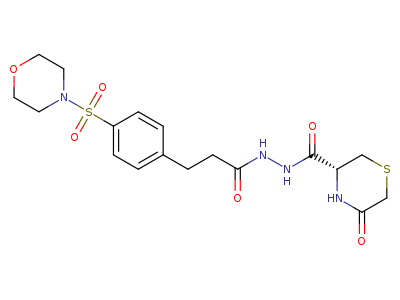

In [28]:
HTML(f'<img src="{json.loads(smiles_to_image(smiles_str="O=C(CCc1ccc(cc1)S(=O)(=O)N1CCOCC1)NNC(=O)[C@@H]1CSCC(=O)N1")["result"])["binaryStructure"]}">')

In [103]:
def get_svg_from_local(ligand):
    image_str = ""
    with open(f"../data/ligand_img/{ligand}.svg") as svg_file:
        svg = base64.b64encode(svg_file.read().encode()).decode("utf-8")
        image_str = f'<img src="data:image/svg+xml;base64,{svg}">'
    return image_str

In [8]:
def display_ligand(ligand_obj):
    return HTML(f'<h3>{ligand_obj["id"]}</h3><img src="{ligand_obj["binaryImg"]}">')


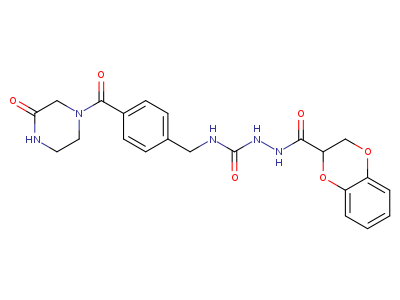

In [9]:
real_id = "Z507663874"
ligand = get_ligand_by_id(real_id=real_id)
if ligand:
    display(display_ligand(ligand_obj=ligand))

In [167]:
smiles_to_image.cache_info()

CacheInfo(hits=105818, misses=42467, maxsize=None, currsize=42457)

In [122]:
# ligand_df2 = pd.read_html(f"../data/{FILENAME}.html")

In [168]:
llist = []
# for i, l in enumerate(ligand_df["Ligand"].values):
for i, s in enumerate(ligand_df["Smiles"].values):
    if i % 5000 == 0:
        print(i)
#     smiles_str = ""
    image_str = ""
#     if not "PV" in l:
#         real_id = l.split("_")[0]
#         ligand = get_ligand_by_id(real_id=real_id)
        
    img_response = smiles_to_image(smiles_str=s)
    if "result" in img_response:
        img = json.loads(img_response["result"])
        image_str = f'<img src="{img["binaryStructure"]}">'
    
    llist.append({"Image": image_str})
        
#         if ligand:
#             image_str = f'<img src="{ligand["binaryImg"]}">'
#             smiles_str = ligand["data"]["smiles"]

#     llist.append({"Image": image_str, "Smiles": smiles_str})

0
5000
10000
15000
20000
25000
30000
35000


In [169]:
# ligand_df = ligand_df.drop(["Image"], axis=1)

In [170]:
ligand_df = pd.concat([ligand_df.reset_index(drop=True), pd.DataFrame(llist)], axis=1)

In [171]:
ligand_df

,Collection,Ligand,Highest-Score,NA,Smiles,Image
0,JBDDDG_00000,PV-001829600218_1_T1,-7.7,1,C[C@@]1(N=C(O)NC1=O)C1=CC=CC(=C1)C(=O)NCCC(=O)...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
1,JBDDCG_00000,PV-001836769525_1_T1,-7.5,1,OC1=NC2(CCCC2)C(=O)N1CC(=O)NNC(=O)CN1CCN(CC1)C...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
2,JBDDCG_00000,PV-001872914269_1_T1,-7.4,1,OC1(CNC(=O)c2cccc(c2)S(=O)(=O)N2CCNC(=O)C2)CCC...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
3,JBDDDG_00000,PV-001829600017_2_T3,-7.4,1,C[C@]1(NC(=O)N=C1O)C1=CC=C(C=C1)C(=O)NCCC(=O)N...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
4,JBDDCG_00000,PV-001850780878_2_T1,-7.3,1,OC1=C(C(=O)NNC(=O)CCN2CCN(CC2)C(=O)[C@H]2CCCO2...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
...,...,...,...,...,...,...
37597,JBFCFG_00000,PV-002008653608_2_T1,-3.5,1,C[C@@H](NS(C)(=O)=O)c1nnc(N2CCC(CC2)S(C)(=O)=O...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
37598,JBFCFG_00001,PV-002041695183_4_T1,-3.5,1,COCC[C@@](C)(O)Cn1c(nnc1N1CCN(CC1)C(=O)[C@@H]1...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
37599,JBEAEG_00000,PV-001939926551_1_T1,-3.4,1,COCCN(CCOC)S(=O)(=O)N1CCN([C@H]2CS(=O)(=O)C[C@...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."
37600,JBFCEG_00003,PV-002035337131_7_T1,-3.3,1,CNC(=O)[C@]1(C)CCN(C1)c1nnc([C@@H](C)OCCOC)n1C...,"<img src=""data:image/png;base64,iVBORw0KGgoAAA..."


In [172]:
# [print(r[1], list(ligand_df["Ligand"].values)[r[0]]) for r in random.sample(list(enumerate(ligand_df["Smiles"].values)), 20)]

In [173]:
html = saxutils.unescape(ligand_df.to_html())

In [174]:
with open(f"../data/{FILENAME}.html", "w") as f:
    f.write(html)

In [175]:
ligand_df.to_csv(f"../data/{FILENAME}.csv")